In [20]:
curr_dir = '/user_data/vayzenbe/GitHub_Repos/ginn'

import sys
sys.path.insert(1, f'{curr_dir}/fmri')

import pandas as pd
import numpy as np
import pdb
import warnings
import os, argparse
import  matplotlib.pyplot as plt



from sklearn.decomposition import PCA
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LinearRegression, Ridge
import brainiak.funcalign.srm
from scipy import stats
import statsmodels.api as sm
from nilearn import image, datasets, plotting, maskers
import nibabel as nib
import random
import statsmodels.api as sm
warnings.filterwarnings("ignore")
print('libraries loaded')

libraries loaded


In [2]:
def extract_pc(data, n_components=None):

    """
    Extract principal components
    if n_components isn't set, it will extract all it can
    """
    
    pca = PCA(n_components = n_components)
    pca.fit(data)
    
    return pca

# %%
def calc_pc_n(pca, thresh):
    '''
    Calculate how many PCs are needed to explain X% of data
    
    pca - result of pca analysis
    thresh- threshold for how many components to keep
    '''
    
    explained_variance = pca.explained_variance_ratio_
    
    var = 0
    for n_components, ev in enumerate(explained_variance):
        var += ev #add each PC's variance to current variance
        #print(n_comp, ev, var)

        if var >=thresh: #once variance > than thresh, stop
            break
    return n_components+1

In [3]:
def calc_mvpd(seed_comps,target_comps, target_pca):
    """
    Conduct regression by iteratively fitting all seed PCs to target PCs
    
    """

    all_scores = []
    for pcn in range(0,len(target_pca.explained_variance_ratio_)):
        
        clf.fit(seed_comps, target_comps[:,pcn]) #fit seed PCs to target
        r_squared = clf.score(seed_comps,target_comps[:,pcn]) 
        
        weighted_corr = r_squared * target_pca.explained_variance_ratio_[pcn]
        all_scores.append(weighted_corr)
        #all_scores.append(r_squared)

    final_corr = np.sum(all_scores)/(np.sum(target_pca.explained_variance_ratio_))
    #final_corr = np.mean(all_scores)
    return final_corr

In [4]:
def create_rdm(ts):
    """
    Create RDM
    """
    rdm = np.corrcoef(ts) * -1
    rdm_vec = rdm[np.triu_indices(n=750,k=1)] #remove lower triangle
    
    return rdm, rdm_vec

In [5]:
human_predictor = '/lab_data/behrmannlab/vlad/ginn/fmri/hbn/derivatives/group_func'
model_predictor = '/lab_data/behrmannlab/vlad/ginn/modelling/model_ts'

exp_dir= f'ginn/fmri/hbn'
study_dir = f'/lab_data/behrmannlab/scratch/vlad/{exp_dir}'
subj_dir=f'{study_dir}/derivatives/preprocessed_data'
roi_dir = f'{study_dir}/derivatives/rois'

subj = 'sub-NDAREG930XPP'



In [6]:
whole_brain_mask = image.load_img('/opt/fsl/6.0.3/data/standard/MNI152_T1_2mm_brain.nii.gz')

bold_vol = image.load_img(f'{subj_dir}/{subj}/{subj}_task-movieDM_bold.nii.gz')
first_volume = image.index_img(bold_vol, 0)
lo_roi = image.load_img(f'{roi_dir}/rLO.nii.gz')
a1_roi = image.load_img(f'{roi_dir}/rA1.nii.gz')


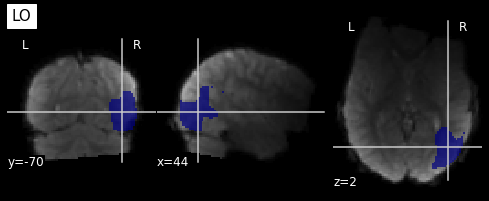

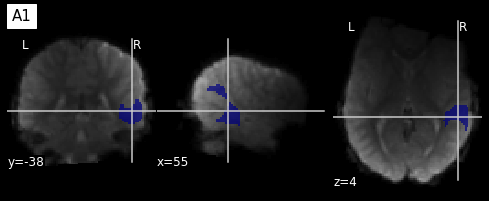

In [7]:
plotting.plot_roi(lo_roi, first_volume, title='LO')
plotting.plot_roi(a1_roi, first_volume, title='A1')

In [14]:
def extract_mv_ts(bold_vol, roi):
    """
    extract multivariate time course from ROI
    """

    #load seed
    roi = image.get_data(roi)
    bold_vol = image.get_data(bold_vol)
    #Just ensure its all binary
    roi[roi>0] = 1
    roi[roi<=0] = 0
    reshaped_roi = np.reshape(roi, whole_brain_mask.shape +(1,))
    masked_img = reshaped_roi*bold_vol

    #extract voxel resposnes from within mask
    mv_ts = masked_img.reshape(-1, bold_vol.shape[3]) #reshape into rows (voxels) x columns (time)
    mv_ts =mv_ts[~np.all(mv_ts == 0, axis=1)] #remove voxels that are 0 (masked out)
    mv_ts = np.transpose(mv_ts)

    print('Seed data extracted...')

    return mv_ts

In [15]:
'''extract data'''

model_ts = np.load(f'{model_predictor}/cornet_z_sl_imagenet_noface_aIT_DM-clip_ts.npy')
adult_ts = np.transpose(np.load(f'{human_predictor}/srm_rLO_18_50.npy'))
lo = extract_mv_ts(bold_vol, lo_roi)
a1 = extract_mv_ts(bold_vol, a1_roi)
whole = extract_mv_ts(bold_vol, whole_brain_mask)



Seed data extracted...
Seed data extracted...
Seed data extracted...


In [36]:
whole_masker = maskers.NiftiMasker(mask_img=whole_brain_mask, detrend = True, standardize = True)
whole_masker.fit(bold_vol)
whole_ts = whole_masker.transform(bold_vol)
mean_ts = np.mean(whole_ts, axis=1)

In [46]:
model_ts = np.load(f'{model_predictor}/cornet_z_sl_imagenet_noface_aIT_DM-clip_ts.npy')
adult_ts = np.transpose(np.load(f'{human_predictor}/srm_rLO_18_50.npy'))

bold_vol_clean = image.clean_img(bold_vol, confounds = mean_ts, detrend = True)

lo_masker = maskers.NiftiMasker(lo_roi, detrend=True, standardize=True)
lo_masker.fit(bold_vol_clean)
lo = lo_masker.transform(bold_vol)

a1_masker = maskers.NiftiMasker(a1_roi, detrend=True, standardize=True)
a1_masker.fit(bold_vol_clean)
a1 = a1_masker.transform(bold_vol)


In [47]:
'''normalize and reduce dimensionality'''

model_ts= stats.zscore(model_ts, axis=1, ddof=1)
adult_ts= stats.zscore(adult_ts, axis=1, ddof=1)


lo_n = calc_pc_n(extract_pc(lo),.9) #determine number of PCs in train_data using threshold        

lo_pca = extract_pc(lo, lo_n) #conduct PCA one more time with that number of PCs
lo_comps = lo_pca.transform(lo) #transform train data in PCs       

a_n = calc_pc_n(extract_pc(a1),.9) #determine number of PCs in train_data using threshold
a1_pca = extract_pc(a1, a_n) #conduct PCA one more time with that number of PCs
a1_comps = a1_pca.transform(a1) #transform train data in PCs

_,lo_rdm_vox = create_rdm(lo)
_,lo_rdm_pc = create_rdm(lo_comps)

_, a1_rdm_vox = create_rdm(a1)
_, a1_rdm_pc = create_rdm(a1_comps)

_,model_rdm = create_rdm(model_ts)


In [48]:
print(lo.shape, a1.shape)
print(lo_comps.shape, a1_comps.shape)
print(model_ts.shape)

(750, 3562) (750, 1493)
(750, 61) (750, 79)
(750, 70)


In [49]:
lo_comps= stats.zscore(lo_comps, axis=1, ddof=1)
a1_comps= stats.zscore(a1_comps, axis=1, ddof=1)

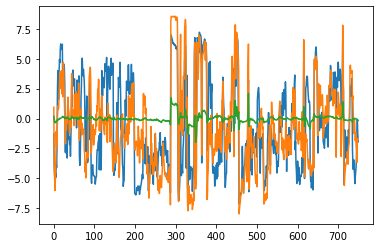

In [50]:
plt.plot(lo_comps[:,0], label='lo_comps')
plt.plot(a1_comps[:,0], label='a1_comps')
plt.plot(mean_ts, label='mean_ts')

In [51]:
print(np.corrcoef(lo_comps[:,0], a1_comps[:,0]))

[[1.         0.71468394]
 [0.71468394 1.        ]]


In [32]:
'''correlate RDMs'''

print(np.corrcoef(lo_rdm_pc,lo_rdm_vox))
print(np.corrcoef(lo_rdm_vox, a1_rdm_vox))
print(np.corrcoef(lo_rdm_pc, a1_rdm_pc))

print(np.corrcoef(lo_rdm_pc, model_rdm))

[[1.         0.81729396]
 [0.81729396 1.        ]]
[[1.         0.70475968]
 [0.70475968 1.        ]]
[[1.         0.67722635]
 [0.67722635 1.        ]]
[[1.         0.12568543]
 [0.12568543 1.        ]]


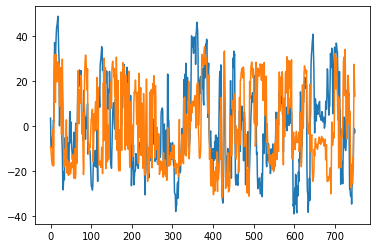

In [54]:
plt.plot(lo_comps[:,1])
plt.plot(a1_comps[:,1])

In [45]:
np.corrcoef(a1_comps[:,0], mean_ts)

array([[1.        , 0.74234016],
       [0.74234016, 1.        ]])

In [29]:
"""
Test model
"""

rois = ['random','imagenet_noface']
sub_comps = a1_comps
sub_pca = a1_pca
all_rois = []
for roi in rois:
    adult_ts = np.load(f'{model_predictor}/cornet_z_sl_{roi}_aIT_DM-clip_ts.npy')
    all_scores = []
    for kk in range(0,adult_ts.shape[1]):
        seed_ts = adult_ts[:,0:kk+1]
        
        curr_score = []
        for jj in range(0,sub_comps.shape[1]):
            
            mod = sm.OLS( sub_comps[:,0],seed_ts).fit()
            r_squared = mod.rsquared

            weighted_corr = r_squared * sub_pca.explained_variance_ratio_[jj]
            curr_score.append(weighted_corr)
        final_corr = np.sum(curr_score)/(np.sum(sub_pca.explained_variance_ratio_))
        all_scores.append(final_corr)
    all_rois.append(all_scores)

DNN a1


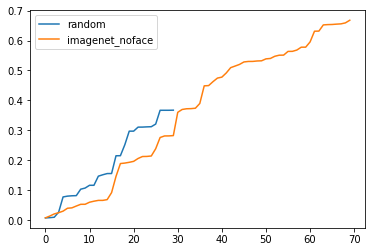

In [30]:
print('DNN a1')
a1_data = all_rois
for rr in range(0,len(rois)):
    plt.plot(a1_data[rr], label=rois[rr])
plt.legend(loc="upper left")


In [20]:
"""
Test ROIs
"""

rois = ['rLO','lLO','lFFA','rFFA']
sub_comps = a1_comps
sub_pca = a1_pca
all_rois = []
for roi in rois:
    adult_ts = np.transpose(np.load(f'{human_predictor}/srm_{roi}_18_50.npy'))
    all_scores = []
    for kk in range(0,adult_ts.shape[1]):
        seed_ts = adult_ts[:,0:kk+1]
        
        curr_score = []
        for jj in range(0,sub_comps.shape[1]):
            
            mod = sm.OLS( sub_comps[:,0],seed_ts).fit()
            r_squared = mod.rsquared

            weighted_corr = r_squared * sub_pca.explained_variance_ratio_[jj]
            curr_score.append(weighted_corr)
        final_corr = np.sum(curr_score)/(np.sum(sub_pca.explained_variance_ratio_))
        all_scores.append(final_corr)
    all_rois.append(all_scores)

lo


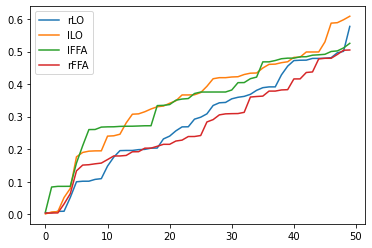

In [12]:
print('lo')
lo_data = all_rois
for rr in range(0,len(rois)):
    plt.plot(lo_data[rr], label=rois[rr])
plt.legend(loc="upper left")


a1


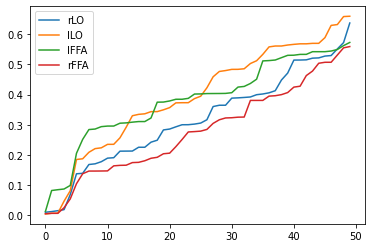

In [21]:
print('a1')
a1_data = all_rois
for rr in range(0,len(rois)):
    plt.plot(a1_data[rr], label=rois[rr])
plt.legend(loc="upper left")


In [24]:
sub_file = f'{subj_dir}/sub-NDAREG930XPP/sub-NDAREG930XPP_task-movieDM_bold.nii.gz'
bold_vol = image.load_img(sub_file) #load data
affine = bold_vol.affine #get affine

In [25]:
test_slice = bold_vol.get_data()[:,:,0]
test_slice = nib.Nifti1Image(test_slice, affine)

In [17]:
roi = f'{study_dir}/derivatives/rois/rA1.nii.gz'

In [28]:
plotting.view_img(bold_vol)

DimensionError: Input data has incompatible dimensionality: Expected dimension is 3D and you provided a 4D image. See https://nilearn.github.io/stable/manipulating_images/input_output.html.

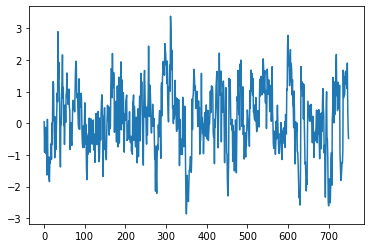

In [35]:
plt.plot(sub_ts[:,0])

In [40]:
np.corrcoef(a1[:,0],adult_ts[:,0])

array([[1.       , 0.0459994],
       [0.0459994, 1.       ]])

LinearRegression()

-0.4109339586423002

In [65]:
mod = sm.OLS( a1[:,0], model_ts)

In [66]:
res = mod.fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.356
Model:                            OLS   Adj. R-squared (uncentered):              0.291
Method:                 Least Squares   F-statistic:                              5.468
Date:                Mon, 04 Jul 2022   Prob (F-statistic):                    5.32e-33
Time:                        16:38:30   Log-Likelihood:                         -827.51
No. Observations:                 750   AIC:                                      1793.
Df Residuals:                     681   BIC:                                      2112.
Df Model:                          69                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0577      0.012     -4.880      0.000      -0.081      -0.034
x2             0.0022      0.015      0.151      0.880      -0.026       0.031
x3             0.0954      0.019      5.079      0.000       0.059       0.132
x4            -0.0343      0.019     -1.809      0.071      -0.071       0.003
x5             0.0292      0.021      1.403      0.161      -0.012       0.070
x6            -0.0336      0.021     -1.640      0.101      -0.074       0.007
x7             0.0298      0.022      1.345      0.179      -0.014       0.073
x8            -0.0043      0.022     -0.199      0.842      -0.047       0.038
x9             0.0313      0.023      1.358      0.175      -0.014       0.077
x10           -0.0293      0.023     -1.257      0.209      -0.075       0.016
x11           -0.0897      0.026     -3.392      0.001      -0.142      -0.038
x12           -0.1140      0.026     -4.370      0.000      -0.165      -0.063
x13            0.0162      0.025      0.639      0.523      -0.034       0.066
x14            0.1132      0.026      4.303      0.000       0.062       0.165
x15            0.0866      0.027      3.189      0.001       0.033       0.140
x16           -0.0235      0.025     -0.924      0.356      -0.074       0.026
x17            0.0540      0.026      2.065      0.039       0.003       0.105
x18           -0.0254      0.029     -0.885      0.376      -0.082       0.031
x19           -0.0388      0.028     -1.383      0.167      -0.094       0.016
x20            0.0876      0.029      3.027      0.003       0.031       0.144
x21           -0.0768      0.032     -2.412      0.016      -0.139      -0.014
x22            0.0187      0.031      0.602      0.547      -0.042       0.080
x23           -0.1050      0.031     -3.371      0.001      -0.166      -0.044
x24            0.0340      0.031      1.089      0.277      -0.027       0.095
x25           -0.0461      0.032     -1.430      0.153      -0.109       0.017
x26            0.0762      0.031      2.458      0.014       0.015       0.137
x27           -0.1358      0.033     -4.094      0.000      -0.201      -0.071
x28           -0.0391      0.032     -1.214      0.225      -0.102       0.024
x29           -0.0599      0.033     -1.804      0.072      -0.125       0.005
x30           -0.0334      0.032     -1.051      0.294      -0.096       0.029
x31           -0.0336      0.033     -1.009      0.314      -0.099       0.032
x32           -0.0299      0.033     -0.918      0.359      -0.094       0.034
x33           -0.0606      0.033     -1.814      0.070      -0.126       0.005
x34            0.1417      0.033      4.249      0.000       0.076       0.207
x35            0.0615      0.034      1.797      0.073      -